In [5]:
from utils.model import light
import torch
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from torchvision import transforms
import torch.nn as nn

# 检查设备信息
light.DeviceUtils.print_device_info()

🔍 设备检测结果:
   PyTorch版本: 2.7.1+cu128
   CUDA可用: ✅
   CUDA版本: 12.8
   GPU数量: 1
   GPU 0: NVIDIA GeForce RTX 4060 (8.0GB)
   MPS (Apple Silicon): ❌
   推荐设备: cuda


In [12]:
import torch
from torch._tensor import Tensor


class LeNet(light.ModernModule):
    def __init__(self, config: light.ModelConfig):
        super().__init__(config)
        self._is_classification = True
        self.net = nn.Sequential(
            nn.LazyConv2d(6, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # layer 2
            nn.LazyConv2d(
                16,
                kernel_size=5,
            ),
            nn.ReLU(), # 
            nn.MaxPool2d(kernel_size=2, stride=2), # layer 5
            nn.Flatten(),
            nn.LazyLinear(120), 
            nn.ReLU(),
            nn.LazyLinear(84), # layer 9
            nn.ReLU(),
            nn.LazyLinear(config.output_size), # layer 11
        )

    def compute_loss(self, y_hat, y) -> Tensor:
        return nn.functional.cross_entropy(y_hat, y)

    def predict(self, x: Tensor):
        return self.net(x).argmax(dim=1)

    def predict_class(self, x: Tensor) -> Tensor:
        return self.predict(x).item()

    def evaluate(self, X, y):
        # 评估模型性能
        # 整体正确率 - FP - FN - F1score - AUC
        with torch.no_grad():
            y_hat = self.net(X)
            loss = self.compute_loss(y_hat, y)
            predicted_class = self.predict(X)
            accuracy = (predicted_class == y).float().mean().item()
            return {
                "loss": loss.item(),
                "accuracy": accuracy,
                "predicted_class": predicted_class,
            }

In [6]:
# 数据准备
datapath = "../../data/"

# transformer = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Normalize((0.2860,), (0.3530,))
# ])

# # 加载数据集
# fashion_mnist_train = datasets.FashionMNIST(
#     root=datapath, train=True, download=True, transform=transformer
# )
# fashion_mnist_test = datasets.FashionMNIST(
#     root=datapath, train=False, download=True, transform=transformer
# )

# # 创建标准数据加载器 - 无需GPU包装器！
# train_loader = DataLoader(
#     fashion_mnist_train, 
#     batch_size=64, 
#     shuffle=True, 
# )
# val_loader = DataLoader(
#     fashion_mnist_test, 
#     batch_size=64, 
#     shuffle=False, 
# )

# num_classes = len(fashion_mnist_train.classes)

color_transforms = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.4914, 0.4822, 0.4465],  # CIFAR-10的RGB均值
            std=[0.2023, 0.1994, 0.2010],  # CIFAR-10的RGB标准差
        ),
    ]
)
# 加载 CIFAR-10 数据集
cifar10_train = datasets.CIFAR10(
    root=datapath, train=True, download=True, transform=color_transforms
)

cifar10_test = datasets.CIFAR10(
    root=datapath,
    train=False,
    download=True,
    transform=color_transforms,  # 测试时不使用数据增强
)

# 创建数据加载器
train_loader = DataLoader(
    cifar10_train, 
    batch_size=128, 
    shuffle=True, 
)

val_loader = DataLoader(
    cifar10_test, 
    batch_size=128, 
    shuffle=False, 
)

num_classes = 10  # CIFAR-10 有10个类别
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
               'dog', 'frog', 'horse', 'ship', 'truck']

print(f"数据集类别数: {num_classes}")

数据集类别数: 10


In [7]:
# 移植后的使用方式
import numpy as np
from scipy.stats import rankdata
# from infonet.infer_light import load_lightning_model, load_lightning_model_alternative
from infonet.infer import load_model

# 加载预训练模型
config_path = "../../configs/infonet/config.yaml"
ckpt_path = "../../data/checkpoint/infonet_cp/model_5000_32_1000-720--0.16.pt"

# try:
model = load_model(config_path, ckpt_path)
print("✅ 使用主要方法成功加载模型")
# except Exception as e:
    # print(f"❌ 主要方法失败: {e}")
    # print("🔄 尝试备用方法...")
    # model = load_lightning_model_alternative(config_path, ckpt_path)
    # print("✅ 使用备用方法成功加载模型")
    # print(f"❌ 加载模型失败: {e}")
# model.device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print(f"使用设备: {device}")
model = model.to(device)

# 通过parameter查看是否在cuda上
for name, param in model.named_parameters():
    if param.device.type == 'cuda':
        print(f"参数 {name} 在 CUDA 上")
    else:
        print(f"参数 {name} 不在 CUDA 上")

✅ 使用主要方法成功加载模型
参数 encoder.latents 在 CUDA 上
参数 encoder.cross_attn_block.cross_attention.q_norm.weight 在 CUDA 上
参数 encoder.cross_attn_block.cross_attention.q_norm.bias 在 CUDA 上
参数 encoder.cross_attn_block.cross_attention.kv_norm.weight 在 CUDA 上
参数 encoder.cross_attn_block.cross_attention.kv_norm.bias 在 CUDA 上
参数 encoder.cross_attn_block.cross_attention.attention.qeury.weight 在 CUDA 上
参数 encoder.cross_attn_block.cross_attention.attention.qeury.bias 在 CUDA 上
参数 encoder.cross_attn_block.cross_attention.attention.key.weight 在 CUDA 上
参数 encoder.cross_attn_block.cross_attention.attention.key.bias 在 CUDA 上
参数 encoder.cross_attn_block.cross_attention.attention.value.weight 在 CUDA 上
参数 encoder.cross_attn_block.cross_attention.attention.value.bias 在 CUDA 上
参数 encoder.cross_attn_block.cross_attention.attention.projection.weight 在 CUDA 上
参数 encoder.cross_attn_block.cross_attention.attention.projection.bias 在 CUDA 上
参数 encoder.cross_attn_block.mlp.mlp.0.weight 在 CUDA 上
参数 encoder.cross_attn_block.mlp

In [6]:
import os
import csv
import pytorch_lightning as pl
from pytorch_lightning.utilities import rank_zero_only
from infonet.infer import compute_smi_mean_gpu
from m3logpy import M3Log
logger = M3Log("better.log")
class DemoCallBack_3(pl.Callback):
    def __init__(self, mi_model, csv_path="mi_epoch_gpu.csv", max_batches_for_mi=100, 
                 layer_count_mi=None, proj_num=1024, seq_len=2000, batchsize=16):
        """
        GPU优化版本的互信息计算回调
        """
        super().__init__()
        self.seq_len = seq_len
        self.proj_num = proj_num
        self.batchsize = batchsize
        self.features = {}
        self.mi_model = mi_model
        self.csv_path = csv_path
        self.max_batches_for_mi = max_batches_for_mi
        self.layer_count_mi = layer_count_mi if layer_count_mi is not None else []
        
        # 获取MI模型的设备
        self.device = next(mi_model.parameters()).device
        
        # 用于累积数据的列表 - 保持在GPU上
        self.inputs_X_for_mi = []
        self.activations_output_for_mi = []
        
        # 用于每个指定层的激活累积
        self.activations_layer_for_mi = {i: [] for i in self.layer_count_mi}
        
        # 写入表头
        if rank_zero_only.rank == 0 and not os.path.exists(self.csv_path):
            with open(self.csv_path, "w", newline="") as f:
                writer = csv.writer(f)
                header = ["epoch"]
                for i in self.layer_count_mi:
                    header.append(f"I(X;Layer_{i})")
                for i in self.layer_count_mi:
                    header.append(f"I(Layer_{i};Output)")
                writer.writerow(header)

    def get_activation(self, name):
        def hook(model, input, output):
            # 保持激活在GPU上，不转移到CPU
            self.features[name] = output.detach()
        return hook

    def on_fit_start(self, trainer, pl_module):
        # 注册钩子以捕获中间层激活
        for i in self.layer_count_mi:
            pl_module.net[i].register_forward_hook(self.get_activation(f"Layer_{i}"))
        # 注册输出层钩子
        pl_module.net[-1].register_forward_hook(self.get_activation("Output"))

    def on_train_batch_end(self, trainer, pl_module, outputs, batch, batch_idx):
        # 只在主进程中执行，并且只收集指定数量的批次
        if trainer.global_rank != 0 or batch_idx >= self.max_batches_for_mi:
            return

        x, y = batch
        # 保持数据在GPU上
        self.inputs_X_for_mi.append(x.detach())
        
        # 收集每个指定层的激活 - 保持在GPU上
        for i in self.layer_count_mi:
            feat = self.features.get(f"Layer_{i}")
            if feat is not None:
                self.activations_layer_for_mi[i].append(feat)
        
        # 收集输出层激活
        feat_out = self.features.get("Output")
        if feat_out is not None:
            self.activations_output_for_mi.append(feat_out)

    def compute_and_log_mi_gpu(self, x, y, name):
        """GPU版本的互信息计算和日志记录"""
        # 保持张量格式，展平非批次维度
        if x.dim() > 2:
            x = x.flatten(1)
        if y.dim() > 2:
            y = y.flatten(1)
        
        # 调用GPU版本的计算函数
        mi = compute_smi_mean_gpu(
            x, y, self.mi_model, 
            proj_num=self.proj_num, 
            seq_len=self.seq_len, 
            batchsize=self.batchsize
        )
        
        logger.info(f"本epoch {name} 互信息 (GPU): {mi:.4f}")
        return mi

    def on_train_epoch_end(self, trainer, pl_module):
        if trainer.global_rank != 0:
            return

        epoch = trainer.current_epoch

        # 检查是否收集到了数据
        if not self.inputs_X_for_mi or not self.activations_output_for_mi:
            logger.warn(f"Epoch {epoch}: 未收集到足够的数据来计算互信息。")
            return

        # 在GPU上拼接数据
        all_X = torch.cat(self.inputs_X_for_mi, dim=0).to(self.device)
        all_T_output = torch.cat(self.activations_output_for_mi, dim=0).to(self.device)

        # 计算所有层的 I(X;T) 和 I(T;Output)
        mi_x_t = []
        mi_t_output = []
        
        for i in self.layer_count_mi:
            activations = self.activations_layer_for_mi[i]
            if activations:
                all_T = torch.cat(activations, dim=0).to(self.device)
                
                # 使用GPU版本计算互信息
                mi_x_layer = self.compute_and_log_mi_gpu(
                    all_X, all_T, f"Input(X) 与 Layer_{i}(T)"
                )
                mi_layer_output = self.compute_and_log_mi_gpu(
                    all_T, all_T_output, f"Layer_{i}(T) 与 Output(Y)"
                )
                
                mi_x_t.append(mi_x_layer)
                mi_t_output.append(mi_layer_output)
            else:
                mi_x_t.append(None)
                mi_t_output.append(None)

        # 保存到CSV
        with open(self.csv_path, "a", newline="") as f:
            writer = csv.writer(f)
            row = [epoch]
            row.extend(mi_x_t)
            row.extend(mi_t_output)
            writer.writerow(row)

        # 清空所有累积（释放GPU内存）
        self.inputs_X_for_mi.clear()
        self.activations_output_for_mi.clear()
        for i in self.layer_count_mi:
            self.activations_layer_for_mi[i].clear()
        
        # 清理GPU缓存
        torch.cuda.empty_cache()

        logger.info(f"Epoch {epoch}: GPU互信息计算和记录完成。")

In [9]:
config_LeNet = light.ModelConfig(
    lr=0.0001,
    num_hiddens=256,
    output_size=num_classes,
    optimizer="adam",
    # 权重衰减
    weight_decay=0.0001,  # 可选的权重衰减
    dropout_rate=0.2,
)

model_ = LeNet(config_LeNet)
model_.to("cuda" if torch.cuda.is_available() else "cpu")
print(model_.device)
print("cuda" if torch.cuda.is_available() else "cpu")

trainer = light.TrainerFactory.basic(
    max_epochs=200,
)
trainer.add_callback(DemoCallBack_3(
    mi_model=model,
    layer_count_mi=[2,5,9,11],
    seq_len=1000,
    proj_num=512,
    batchsize=16,
    csv_path="lenet_mi_1.csv"  # 保存互信息结果的CSV文件路径
))
trainer.add_callback(
    light.HighFrequencyLiveLossPlotCallback(update_every_n_batches=300
                                            )
)

cuda:0
cuda


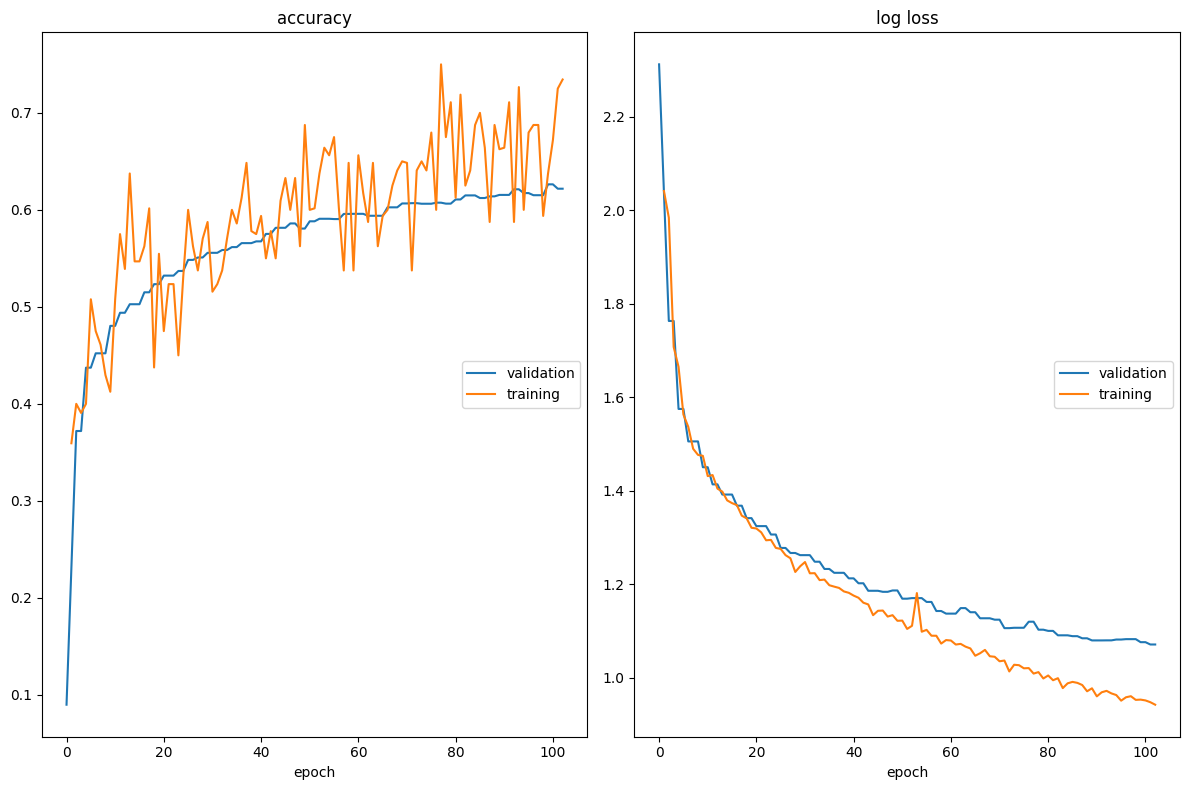

accuracy
	validation       	 (min:    0.090, max:    0.626, cur:    0.622)
	training         	 (min:    0.359, max:    0.750, cur:    0.734)
log loss
	validation       	 (min:    1.071, max:    2.312, cur:    1.071)
	training         	 (min:    0.942, max:    2.041, cur:    0.942)
Epoch 44:  56%|█████▌    | 218/391 [00:11<00:08, 19.74it/s, v_num=23, train_loss=1.030, train_acc=0.688, val_loss=1.070, val_acc=0.622]


Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

In [10]:
trainer.fit(
    model=model_,
    train_loader=train_loader,
    val_loader=val_loader,
)

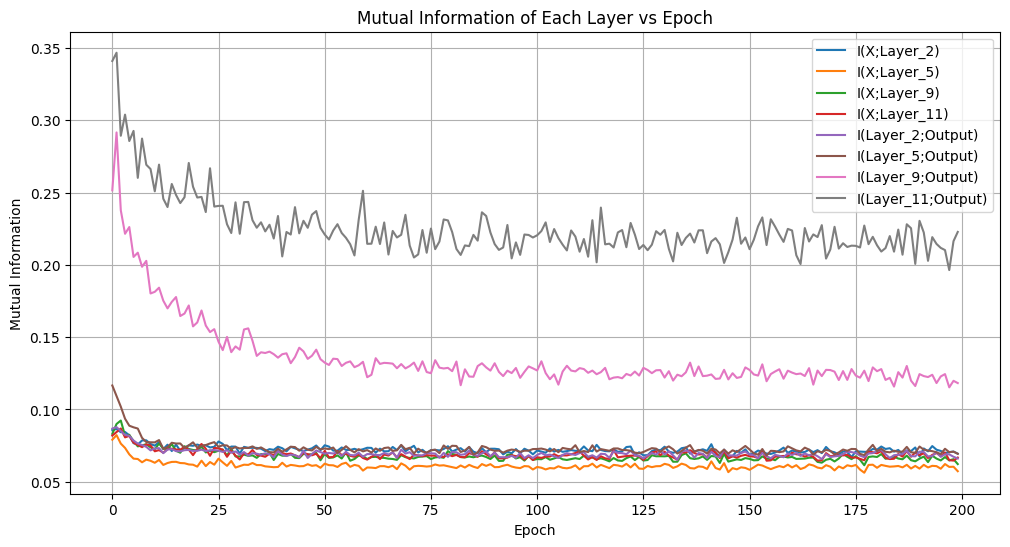

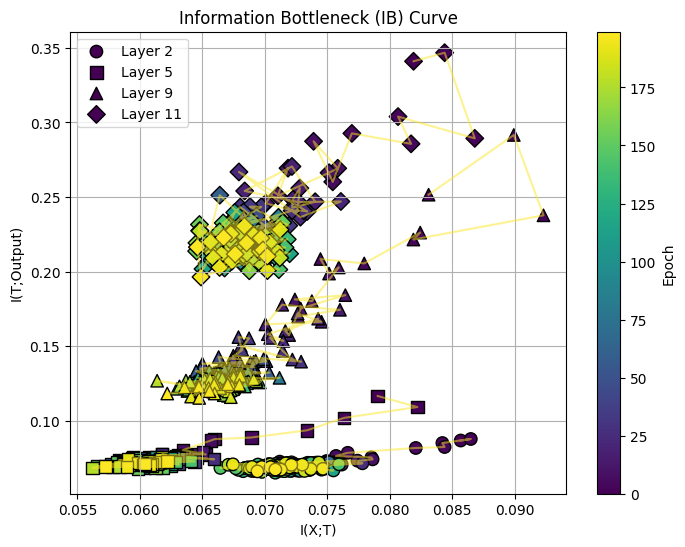

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Read the data
df = pd.read_csv("lenet_mi.csv")

# Plot mutual information of each layer vs epoch
plt.figure(figsize=(12, 6))
for col in df.columns:
    if col != "epoch":
        plt.plot(df["epoch"], df[col], label=col)
plt.xlabel("Epoch")
plt.ylabel("Mutual Information")
plt.title("Mutual Information of Each Layer vs Epoch")
plt.legend()
plt.grid(True)
plt.show()

# Plot IB curve (I(X;T) vs I(T;Output)), color represents epoch, marker shape represents layer, with lines
plt.figure(figsize=(8, 6))
layer_ids = [2, 5, 9, 11]
markers = ['o', 's', '^', 'D']  # Different marker for each layer
cmap = plt.cm.viridis
norm = plt.Normalize(df["epoch"].min(), df["epoch"].max())

for i, layer in enumerate(layer_ids):
    x = df[f"I(X;Layer_{layer})"]
    y = df[f"I(Layer_{layer};Output)"]
    epochs = df["epoch"]
    # Draw lines connecting the points for each layer
    plt.plot(x, y, color=cmap(norm(epochs.iloc[-1])), alpha=0.5)
    # Scatter points with color representing epoch and marker for layer
    sc = plt.scatter(x, y, c=epochs, cmap=cmap, marker=markers[i], label=f"Layer {layer}", edgecolors='k', s=80)

plt.xlabel("I(X;T)")
plt.ylabel("I(T;Output)")
plt.title("Information Bottleneck (IB) Curve")
plt.legend()
cbar = plt.colorbar(sc)
cbar.set_label('Epoch')
plt.grid(True)
plt.show()

In [8]:
class ResNeXtBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, cardinality=32):
        super().__init__()
        width = out_channels // 2
        
        self.main_path = nn.Sequential(
            nn.Conv2d(in_channels, width, 1, bias=False),
            nn.BatchNorm2d(width),
            nn.ReLU(inplace=True),
            nn.Conv2d(width, width, 3, stride, 1, groups=cardinality, bias=False),
            nn.BatchNorm2d(width), 
            nn.ReLU(inplace=True),
            nn.Conv2d(width, out_channels, 1, bias=False),
            nn.BatchNorm2d(out_channels)
        )
        
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 1, stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
        
        self.relu = nn.ReLU(inplace=True)
    
    def forward(self, x):
        return self.relu(self.main_path(x) + self.shortcut(x))
    
class ResNeXt_Better(light.ModernModule):
    def __init__(self, config: light.ModelConfig):
        super().__init__(config)
        self._is_classification = True

        # 初始层
        self.stem = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
        )

        # ResNeXt层 - 这里不能用Sequential包含ResNeXtBlock
        self.layer1 = self.make_stage(64, 128, 1, 32, 2)  # 输出分辨率不变
        self.layer2 = self.make_stage(128, 256, 2, 32, 2) # 下采样
        self.layer3 = self.make_stage(256, 512, 2, 32, 2) # 下采样


        # 分类器
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Dropout(config.dropout_rate),
            nn.Linear(512, config.output_size),
        )

    def make_stage(self, in_c, out_c, stride, cardinality, blocks):
        layers = [ResNeXtBlock(in_c, out_c, stride, cardinality)]
        for _ in range(1, blocks):
            layers.append(ResNeXtBlock(out_c, out_c, 1, cardinality))
        return nn.Sequential(*layers)


    def forward(self, x):
        x = self.stem(x)
        x = self.layer1(x)  # 必须逐个调用
        x = self.layer2(x)
        x = self.layer3(x)
        return self.classifier(x)

    def compute_loss(self, y_hat, y):
        return nn.functional.cross_entropy(y_hat, y)

    def predict(self, x):
        return self.forward(x).argmax(dim=1)

    def predict_class(self, x):
        return self.predict(x).item()

    def evaluate(self, X, y):
        with torch.no_grad():
            y_hat = self.forward(X)
            loss = self.compute_loss(y_hat, y)
            predicted_class = self.predict(X)
            accuracy = (predicted_class == y).float().mean().item()
            return {
                "loss": loss.item(),
                "accuracy": accuracy,
                "predicted_class": predicted_class,
            }


In [9]:
import os
import csv
import pytorch_lightning as pl
from pytorch_lightning.utilities import rank_zero_only
from infonet.infer import compute_smi_mean_gpu
from m3logpy import M3Log

logger = M3Log("resnext_mi.log")

class ResNeXtMICallback(pl.Callback):
    def __init__(self, mi_model, csv_path="resnext_mi.csv", max_batches_for_mi=50, 
                 layer_specs=None, proj_num=256, seq_len=500, batchsize=8):
        """
        专门为ResNeXt设计的互信息分析回调
        
        Args:
            mi_model: 互信息估计模型
            csv_path: 保存结果的CSV文件路径
            max_batches_for_mi: 每个epoch用于MI计算的最大批次数
            layer_specs: 指定要分析的层，格式为:
                [
                    ("stem", "stem层"),
                    ("layer1", "第一个ResNeXt阶段"),
                    ("layer2", "第二个ResNeXt阶段"),
                    ("layer3", "第三个ResNeXt阶段"),
                    ("classifier", "分类器")
                ]
            proj_num: 投影数量
            seq_len: 序列长度
            batchsize: 批次大小
        """
        super().__init__()
        self.seq_len = seq_len
        self.proj_num = proj_num
        self.batchsize = batchsize
        self.features = {}
        self.mi_model = mi_model
        self.csv_path = csv_path
        self.max_batches_for_mi = max_batches_for_mi
        
        # 默认的层规格
        if layer_specs is None:
            self.layer_specs = [
                ("stem", "Stem"),
                ("layer1", "Layer1"),
                ("layer2", "Layer2"), 
                ("layer3", "Layer3"),
                ("classifier", "Classifier")
            ]
        else:
            self.layer_specs = layer_specs
        
        # 获取MI模型的设备
        self.device = next(mi_model.parameters()).device
        
        # 用于累积数据的列表
        self.inputs_X_for_mi = []
        self.activations_for_mi = {name: [] for name, _ in self.layer_specs}
        
        # 写入CSV表头
        if rank_zero_only.rank == 0 and not os.path.exists(self.csv_path):
            with open(self.csv_path, "w", newline="") as f:
                writer = csv.writer(f)
                header = ["epoch"]
                
                # I(X;T) 列
                for _, display_name in self.layer_specs:
                    header.append(f"I(X;{display_name})")
                
                # I(T;Output) 列 (除了最后一层)
                for _, display_name in self.layer_specs[:-1]:
                    header.append(f"I({display_name};Output)")
                
                writer.writerow(header)

    def get_activation(self, name):
        def hook(module, input, output):
            # 保持激活在GPU上
            self.features[name] = output.detach()
        return hook

    def on_fit_start(self, trainer, pl_module):
        """在训练开始时注册钩子"""
        # 为每个指定的层注册钩子
        for layer_name, _ in self.layer_specs:
            if hasattr(pl_module, layer_name):
                layer = getattr(pl_module, layer_name)
                layer.register_forward_hook(self.get_activation(layer_name))
                logger.info(f"已为 {layer_name} 注册钩子")
            else:
                logger.warn(f"警告: 模型中未找到层 {layer_name}")

    def on_train_batch_end(self, trainer, pl_module, outputs, batch, batch_idx):
        """在每个训练批次结束时收集数据"""
        if trainer.global_rank != 0 or batch_idx >= self.max_batches_for_mi:
            return

        x, y = batch
        # 保持输入数据在GPU上
        self.inputs_X_for_mi.append(x.detach())
        
        # 收集每个层的激活
        for layer_name, _ in self.layer_specs:
            feat = self.features.get(layer_name)
            if feat is not None:
                self.activations_for_mi[layer_name].append(feat)

    def compute_and_log_mi_gpu(self, x, y, name):
        """GPU版本的互信息计算"""
        # 展平非批次维度
        if x.dim() > 2:
            x = x.flatten(1)
        if y.dim() > 2:
            y = y.flatten(1)
        
        # 调用GPU版本的计算函数
        mi = compute_smi_mean_gpu(
            x, y, self.mi_model, 
            proj_num=self.proj_num, 
            seq_len=self.seq_len, 
            batchsize=self.batchsize
        )
        
        logger.info(f"本epoch {name} 互信息 (GPU): {mi:.4f}")
        return mi

    def on_train_epoch_end(self, trainer, pl_module):
        """在每个训练epoch结束时计算并保存MI"""
        if trainer.global_rank != 0:
            return

        epoch = trainer.current_epoch

        # 检查是否收集到了数据
        if not self.inputs_X_for_mi:
            logger.warn(f"Epoch {epoch}: 未收集到足够的数据来计算互信息。")
            return

        # 在GPU上拼接输入数据
        all_X = torch.cat(self.inputs_X_for_mi, dim=0).to(self.device)
        
        # 拼接所有层的激活
        all_activations = {}
        for layer_name, _ in self.layer_specs:
            activations = self.activations_for_mi[layer_name]
            if activations:
                all_activations[layer_name] = torch.cat(activations, dim=0).to(self.device)

        # 获取输出层（最后一层）用于计算 I(T;Output)
        output_layer_name = self.layer_specs[-1][0]
        output_activations = all_activations.get(output_layer_name)

        # 计算互信息
        mi_results = []
        
        # 计算 I(X;T) 对于所有层
        for layer_name, display_name in self.layer_specs:
            if layer_name in all_activations:
                mi_x_t = self.compute_and_log_mi_gpu(
                    all_X, all_activations[layer_name], 
                    f"Input(X) 与 {display_name}(T)"
                )
                mi_results.append(mi_x_t)
            else:
                mi_results.append(None)
        
        # 计算 I(T;Output) 对于除最后一层外的所有层
        if output_activations is not None:
            for layer_name, display_name in self.layer_specs[:-1]:
                if layer_name in all_activations:
                    mi_t_output = self.compute_and_log_mi_gpu(
                        all_activations[layer_name], output_activations,
                        f"{display_name}(T) 与 Output(Y)"
                    )
                    mi_results.append(mi_t_output)
                else:
                    mi_results.append(None)

        # 保存到CSV
        with open(self.csv_path, "a", newline="") as f:
            writer = csv.writer(f)
            row = [epoch] + mi_results
            writer.writerow(row)

        # 清空累积数据，释放GPU内存
        self.inputs_X_for_mi.clear()
        for layer_name in self.activations_for_mi:
            self.activations_for_mi[layer_name].clear()
        
        # 清理GPU缓存
        torch.cuda.empty_cache()

        logger.info(f"Epoch {epoch}: ResNeXt GPU互信息计算和记录完成。")


config_ResNeXt = light.ModelConfig(
    lr=0.001,
    num_hiddens=512,
    output_size=num_classes,
    optimizer="adam",
    weight_decay=0.0001,
    dropout_rate=0.1,
)

# 创建模型
model_resnext = ResNeXt_Better(config_ResNeXt)
model_resnext.to("cuda" if torch.cuda.is_available() else "cpu")

# 创建训练器
trainer = light.TrainerFactory.basic(max_epochs=100)

# 添加MI分析回调 - 使用保守的参数设置
trainer.add_callback(ResNeXtMICallback(
    mi_model=model,  # 使用之前加载的InfoNet模型
    layer_specs=[
        ("stem", "Stem"),
        ("layer1", "Layer1"),
        ("layer2", "Layer2"), 
        ("layer3", "Layer3"),
        ("classifier", "Classifier")
    ],
    seq_len=1000,          # 较小的序列长度
    proj_num=512,         # 较少的投影数量
    batchsize=16,          # 较小的批次大小
    # max_batches_for_mi=25, # 较少的MI计算批次
    csv_path="resnext_mi_analysis.csv"
))

# 添加损失可视化回调
trainer.add_callback(
    light.HighFrequencyLiveLossPlotCallback(update_every_n_batches=500)
)


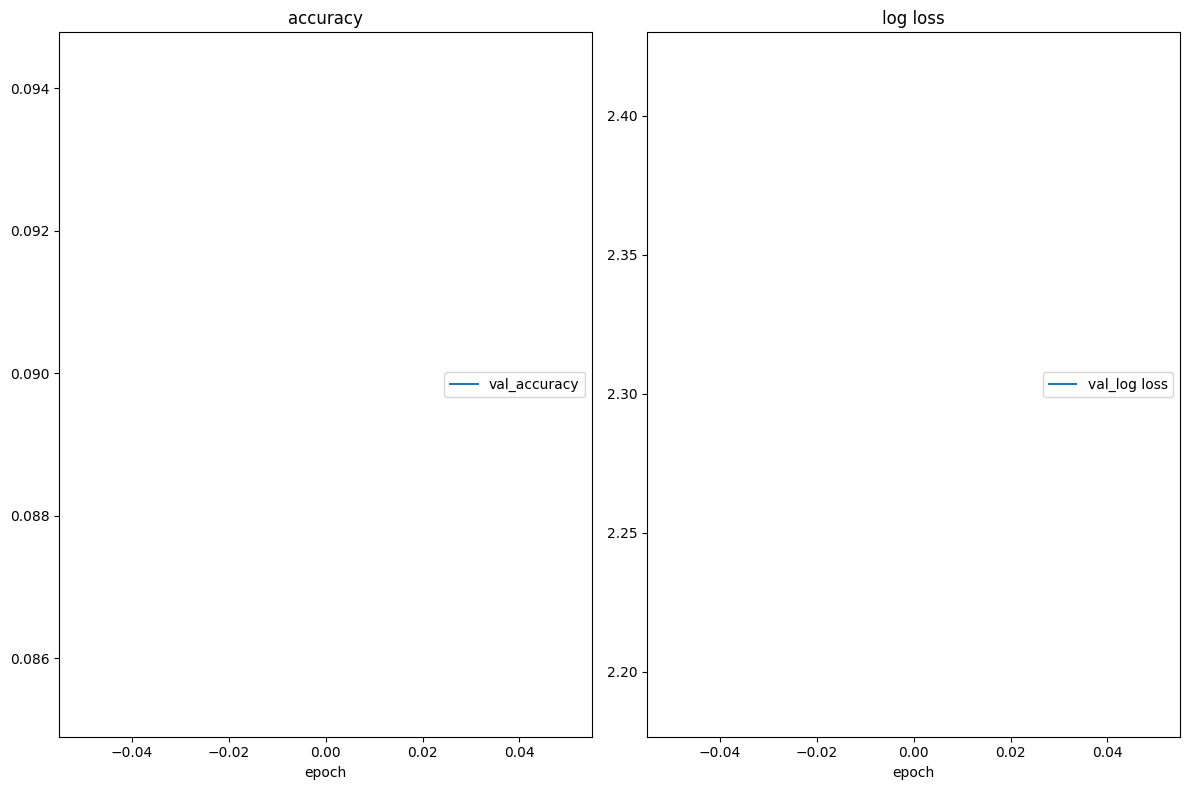

accuracy
	val_accuracy     	 (min:    0.090, max:    0.090, cur:    0.090)
log loss
	val_log loss     	 (min:    2.303, max:    2.303, cur:    2.303)
                                                                           

c:\Src\SevFoxie\SevFoxie\Study\2025Summer\DeepLearning\code\.venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Epoch 0:   2%|▏         | 8/391 [00:26<21:21,  0.30it/s, v_num=25, train_loss=1.900, train_acc=0.320]

In [ ]:
trainer.fit(
    model=model_resnext,
    train_loader=train_loader,
    val_loader=val_loader,
)

<Figure size 1500x1000 with 0 Axes>

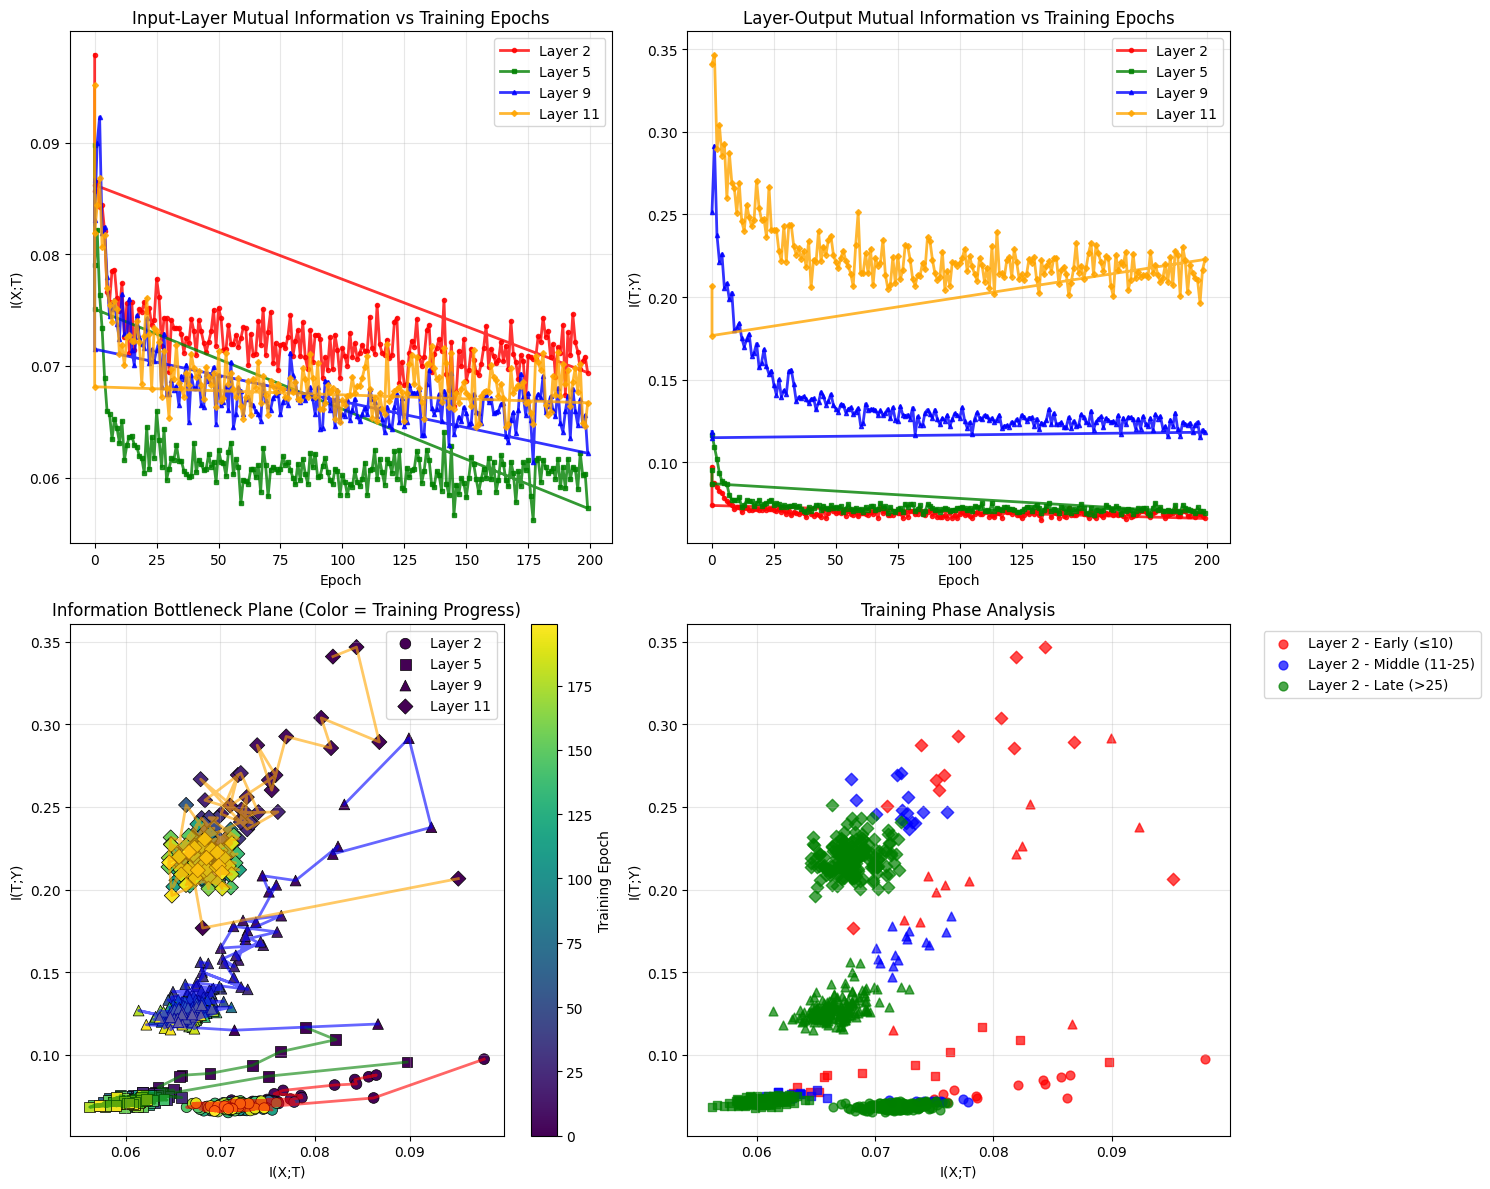

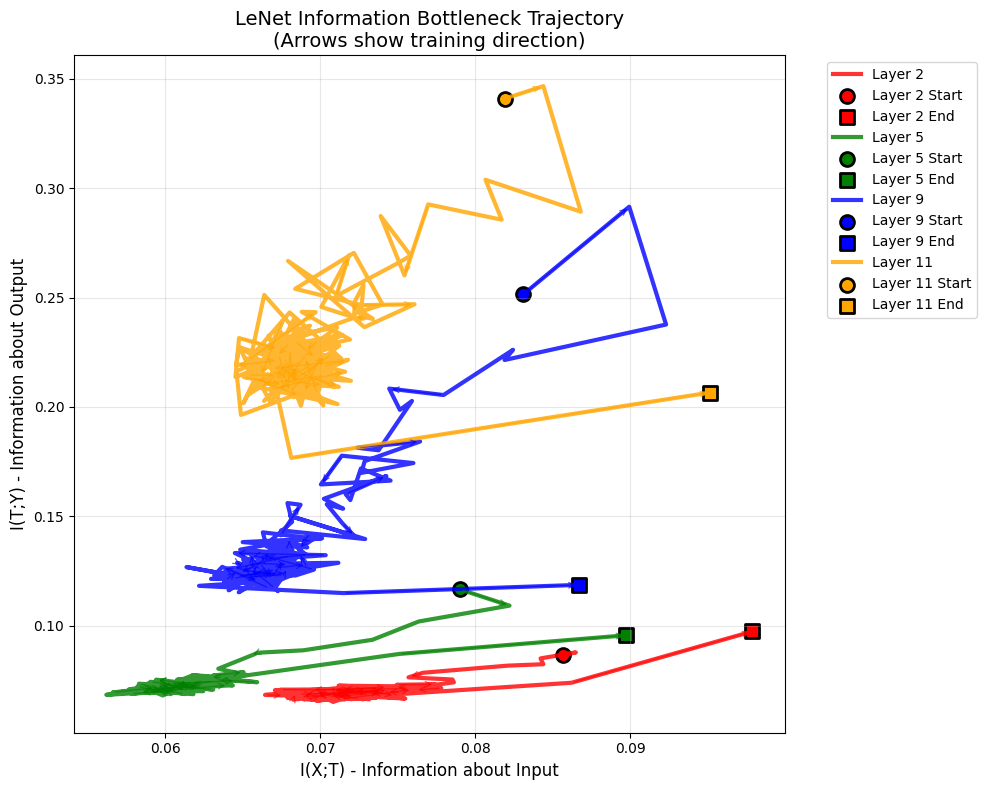

=== LeNet 训练阶段分析 ===
总训练轮数: 202 epochs
I(X;T) 范围: 0.0562 - 0.0979
I(T;Y) 范围: 0.0651 - 0.3467

Layer 2:
  I(X;T): 0.0857 → 0.0979 (变化: +0.0122)
  I(T;Y): 0.0867 → 0.0974 (变化: +0.0107)

Layer 5:
  I(X;T): 0.0790 → 0.0897 (变化: +0.0107)
  I(T;Y): 0.1166 → 0.0956 (变化: -0.0209)

Layer 9:
  I(X;T): 0.0831 → 0.0867 (变化: +0.0036)
  I(T;Y): 0.2515 → 0.1187 (变化: -0.1329)

Layer 11:
  I(X;T): 0.0819 → 0.0951 (变化: +0.0132)
  I(T;Y): 0.3410 → 0.2066 (变化: -0.1344)


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 读取数据
df = pd.read_csv("lenet_mi.csv")

# 1. 绘制类似ERM论文风格的IB曲线
plt.figure(figsize=(15, 10))

# 创建子图
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# 1. 互信息随epoch变化 (类似论文的训练过程分析)
layer_ids = [2, 5, 9, 11]
colors = ['red', 'green', 'blue', 'orange']
markers = ['o', 's', '^', 'D']

# I(X;T) - 输入与各层的互信息
for i, layer in enumerate(layer_ids):
    col_name = f"I(X;Layer_{layer})"
    ax1.plot(df["epoch"], df[col_name], 
             color=colors[i], marker=markers[i], markersize=3,
             label=f"Layer {layer}", linewidth=2, alpha=0.8)

ax1.set_xlabel("Epoch")
ax1.set_ylabel("I(X;T)")
ax1.set_title("Input-Layer Mutual Information vs Training Epochs")
ax1.legend()
ax1.grid(True, alpha=0.3)

# I(T;Y) - 各层与输出的互信息
for i, layer in enumerate(layer_ids):
    col_name = f"I(Layer_{layer};Output)"
    ax2.plot(df["epoch"], df[col_name], 
             color=colors[i], marker=markers[i], markersize=3,
             label=f"Layer {layer}", linewidth=2, alpha=0.8)

ax2.set_xlabel("Epoch")
ax2.set_ylabel("I(T;Y)")
ax2.set_title("Layer-Output Mutual Information vs Training Epochs")
ax2.legend()
ax2.grid(True, alpha=0.3)

# 2. 信息平面图 (Information Plane) - 类似论文的核心图
# 使用颜色表示训练阶段，用线条连接同一层的轨迹
cmap = plt.cm.viridis
norm = plt.Normalize(df["epoch"].min(), df["epoch"].max())

for i, layer in enumerate(layer_ids):
    x_col = f"I(X;Layer_{layer})"
    y_col = f"I(Layer_{layer};Output)"
    
    x = df[x_col]
    y = df[y_col]
    epochs = df["epoch"]
    
    # 绘制轨迹线
    ax3.plot(x, y, color=colors[i], alpha=0.6, linewidth=2)
    
    # 绘制散点，颜色表示epoch
    scatter = ax3.scatter(x, y, c=epochs, cmap=cmap, 
                         marker=markers[i], s=60, 
                         label=f"Layer {layer}", 
                         edgecolors='black', linewidth=0.5)

ax3.set_xlabel("I(X;T)")
ax3.set_ylabel("I(T;Y)")
ax3.set_title("Information Bottleneck Plane (Color = Training Progress)")
ax3.legend()
ax3.grid(True, alpha=0.3)

# 添加颜色条
cbar = plt.colorbar(scatter, ax=ax3)
cbar.set_label('Training Epoch')

# 3. 分析不同训练阶段的特征
# 定义阶段（您可以根据损失下降情况调整这些边界）
early_phase = df["epoch"] <= 10    # 早期阶段
middle_phase = (df["epoch"] > 10) & (df["epoch"] <= 25)  # 中期阶段  
late_phase = df["epoch"] > 25      # 后期阶段

phase_colors = ['red', 'blue', 'green']
phase_labels = ['Early (≤10)', 'Middle (11-25)', 'Late (>25)']
phases = [early_phase, middle_phase, late_phase]

for i, layer in enumerate(layer_ids):
    x_col = f"I(X;Layer_{layer})"
    y_col = f"I(Layer_{layer};Output)"
    
    for j, (phase, color, label) in enumerate(zip(phases, phase_colors, phase_labels)):
        x_phase = df[phase][x_col]
        y_phase = df[phase][y_col]
        
        if len(x_phase) > 0:
            ax4.scatter(x_phase, y_phase, 
                       color=color, marker=markers[i], 
                       alpha=0.7, s=40,
                       label=f"Layer {layer} - {label}" if i == 0 else "")

ax4.set_xlabel("I(X;T)")
ax4.set_ylabel("I(T;Y)")
ax4.set_title("Training Phase Analysis")
ax4.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 4. 单独绘制更详细的信息平面轨迹图
plt.figure(figsize=(10, 8))

for i, layer in enumerate(layer_ids):
    x_col = f"I(X;Layer_{layer})"
    y_col = f"I(Layer_{layer};Output)"
    
    x = df[x_col]
    y = df[y_col]
    epochs = df["epoch"]
    
    # 绘制轨迹
    plt.plot(x, y, color=colors[i], alpha=0.8, linewidth=3, label=f"Layer {layer}")
    
    # 标记起点和终点
    plt.scatter(x.iloc[0], y.iloc[0], color=colors[i], marker='o', s=100, 
               edgecolors='black', linewidth=2, label=f"Layer {layer} Start")
    plt.scatter(x.iloc[-1], y.iloc[-1], color=colors[i], marker='s', s=100, 
               edgecolors='black', linewidth=2, label=f"Layer {layer} End")
    
    # 添加箭头指示方向
    for j in range(0, len(x)-1, 5):  # 每5个epoch添加一个箭头
        plt.annotate('', xy=(x.iloc[j+1], y.iloc[j+1]), xytext=(x.iloc[j], y.iloc[j]),
                    arrowprops=dict(arrowstyle='->', color=colors[i], alpha=0.6))

plt.xlabel("I(X;T) - Information about Input", fontsize=12)
plt.ylabel("I(T;Y) - Information about Output", fontsize=12)
plt.title("LeNet Information Bottleneck Trajectory\n(Arrows show training direction)", fontsize=14)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 5. 数值分析 - 寻找可能的阶段转换点
print("=== LeNet 训练阶段分析 ===")
print(f"总训练轮数: {len(df)} epochs")
print(f"I(X;T) 范围: {df[[f'I(X;Layer_{l})' for l in layer_ids]].min().min():.4f} - {df[[f'I(X;Layer_{l})' for l in layer_ids]].max().max():.4f}")
print(f"I(T;Y) 范围: {df[[f'I(Layer_{l};Output)' for l in layer_ids]].min().min():.4f} - {df[[f'I(Layer_{l};Output)' for l in layer_ids]].max().max():.4f}")

# 分析每层的信息变化趋势
for layer in layer_ids:
    x_col = f"I(X;Layer_{layer})"
    y_col = f"I(Layer_{layer};Output)"
    
    x_start, x_end = df[x_col].iloc[0], df[x_col].iloc[-1]
    y_start, y_end = df[y_col].iloc[0], df[y_col].iloc[-1]
    
    print(f"\nLayer {layer}:")
    print(f"  I(X;T): {x_start:.4f} → {x_end:.4f} (变化: {x_end-x_start:+.4f})")
    print(f"  I(T;Y): {y_start:.4f} → {y_end:.4f} (变化: {y_end-y_start:+.4f})")